In this dataset we are forecasting the Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales based on historical price by using Artificial Neural Network (using LSTM neurons) and Facebook's Prophet library

Ref: https://fred.stlouisfed.org/series/S4248SM144NCEN


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import init_notebook_mode,plot,iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
df= pd.read_csv(r'C:\Univ\3rd Semester\Data science\Tiime Series\UDEMY_TSA_FINAL\Data\Alcohol_Sales.csv', index_col='DATE',parse_dates=True)

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.index.freq= 'MS'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Freq: MS
Data columns (total 1 columns):
S4248SM144NCEN    325 non-null int64
dtypes: int64(1)
memory usage: 5.1 KB


In [10]:
df.isna().sum()

S4248SM144NCEN    0
dtype: int64

In [11]:
df.columns=['Sales_price']

In [12]:
df.head()

,Sales_price
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [14]:
trace0 = go.Scatter(x=df.index, y=df.Sales_price, name='Sales_price')
layout = dict(title={'text': "The line plot of Sales Price",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Sales Price in $')
            )
data = [trace0]

fig = go.Figure(data = data, layout = layout)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

Unlike the ARIMA FAMILY of time series models we donot require the time-series to be stationary for modelling through ANN but we need the data to be scaled otherwise the model's performance will be poor. But before scaling let's explore the data to check for any time-series properties such as trends and seasonality and plot the ACF and PACF 

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
results_seasonal_decompose = seasonal_decompose(df)

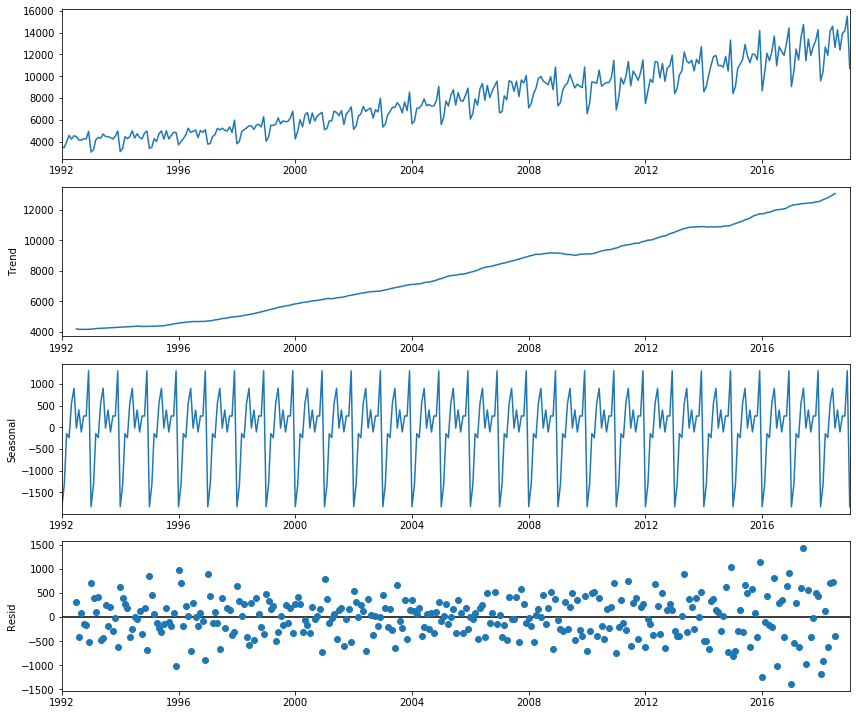

In [18]:
from pylab import rcParams
rcParams['figure.figsize']= 12,10
results_seasonal_decompose.plot();


From the seasonal decomposition plot we can see that the presence of trend and seasonality in the data and the residuals are having the resemblance of white noise

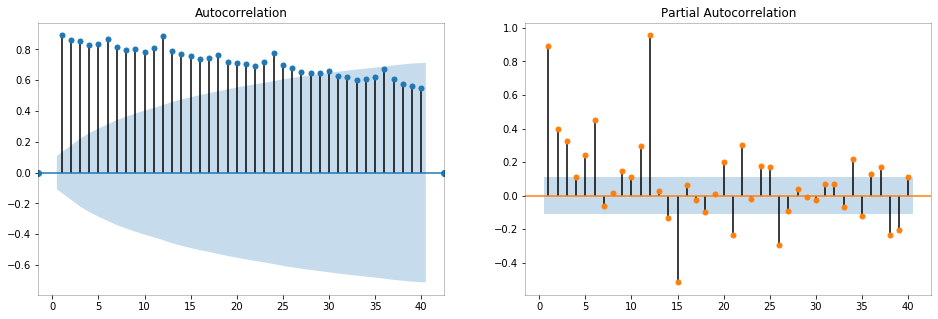

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
plot_acf(df['Sales_price'],lags=40, ax=ax1, marker='o',zero=False) #using 40 past values only as more values will clutter the plot
plot_pacf(df['Sales_price'],lags=40, ax=ax2,method='ols',zero=False,color='tab:orange') #zero = false to remove the first data
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

plt.show()


From the ACF plot we can see that there is a seaonality for each 6 months and the PACF plot indicates that the past 15 values have influence over current sales price

# Data Partitioning

In [20]:
df.tail()

,Sales_price
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


When exploring the whole dataset we can see that the price values are there till 2019 Jan so we will keep aside the whole year of 2018 for testing purposes (ie) last 13 data points)

In [21]:
train = df[:-13]
test = df[-13:]

In [22]:
train.shape

(312, 1)

In [23]:
test.shape

(13, 1)

In [24]:
train.tail()

,Sales_price
DATE,
2017-08-01,13402
2017-09-01,11907
2017-10-01,12711
2017-11-01,13261
2017-12-01,14265


# Data Scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()
scaler.fit(train)
train_sc = scaler.transform(train)
test_sc = scaler.transform(test)

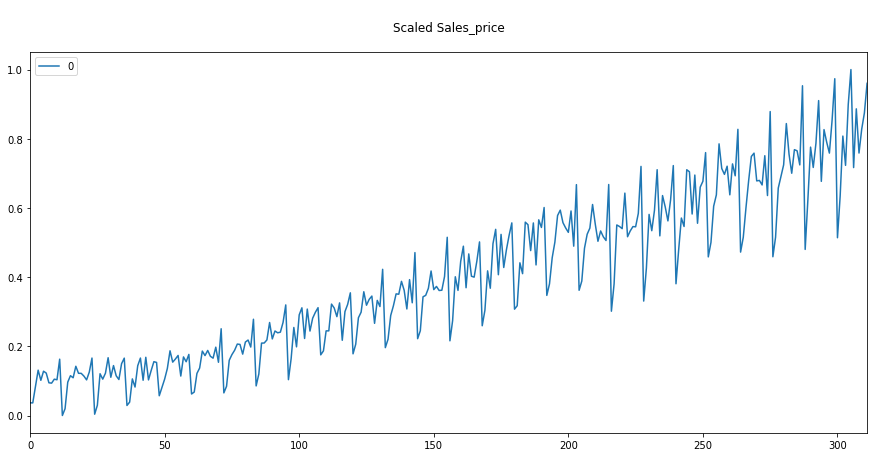

In [35]:
pd.DataFrame(train_sc).plot(figsize=(15,7),title='\nScaled Sales_price\n', label= "Sales price", legend=True);

The above plot shows the same patterns and trends as like before the scaling but just all the values are inbetween 0 and 1

# Data Preparation- Timeseriesgenerator

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [96]:
from keras.preprocessing.sequence import TimeseriesGenerator;

In [201]:
train_sc[:10]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624]])

we can see that the scaler output always be an array which now needs to be converted into a small dataframe with 6 columns each 

In [172]:
# define generator
n_input = 12 #no of columns in the training dataframe
n_features = 1  #no of variables (y)
generator = TimeseriesGenerator(train_sc, train_sc, length=n_input, batch_size=1)

Now we have created the input data frame for the ANN model, lets explore the generator how it looks

In [173]:
x,y =generator[0]

In [174]:
x

array([[[0.03658432],
        [0.03649885],
        [0.08299855],
        [0.13103684],
        [0.1017181 ],
        [0.12804513],
        [0.12266006],
        [0.09453799],
        [0.09359774],
        [0.10496624],
        [0.10334217],
        [0.16283443]]])

In [175]:
y

array([[0.]])

# Data Modelling

In [176]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

In [177]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu',return_sequences=False,input_shape=(n_input, n_features)))
#use return_sequences=True if the next layer is an LSTM right next to the LSTM layer
#model.add(LSTM(40, activation='relu',dropout=0.2))
model.add(Dense(1))  #if the target variable is continuous no need to give the activation function as by default it is linear
model.compile(optimizer='adam', loss='mse')

In [178]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [179]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
300/300 [==============================] - 10s 35ms/step - loss: 0.0149
Epoch 2/50
300/300 [==============================] - 7s 23ms/step - loss: 0.0091
Epoch 3/50
300/300 [==============================] - 7s 22ms/step - loss: 0.0088
Epoch 4/50
300/300 [==============================] - 7s 22ms/step - loss: 0.0080
Epoch 5/50
300/300 [==============================] - 6s 21ms/step - loss: 0.0052
Epoch 6/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0040
Epoch 7/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0030
Epoch 8/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0030
Epoch 9/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0024
Epoch 10/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0022
Epoch 11/50
300/300 [==============================] - 6s 20ms/step - loss: 0.0020: 0s
Epoch 12/50
300/300 [==============================] - 8s 27ms/step - loss: 0.0028
Epoch 13

In [200]:
loss_per_epoch = model.history.history['loss']


trace0 = go.Line(x=list(range(len(loss_per_epoch))), y=loss_per_epoch, name='Loss');
layout = dict(title={'text': "Epochs vs Loss\n",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
              xaxis = dict(title = 'Epochs'),
              yaxis = dict(title = 'Loss')
            );
data = [trace0]

fig = go.Figure(data = data, layout = layout);
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
));
fig.show();

In [181]:
test_predictions = []

first_eval_batch = train_sc[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [182]:
true_predictions = scaler.inverse_transform(test_predictions)

In [183]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

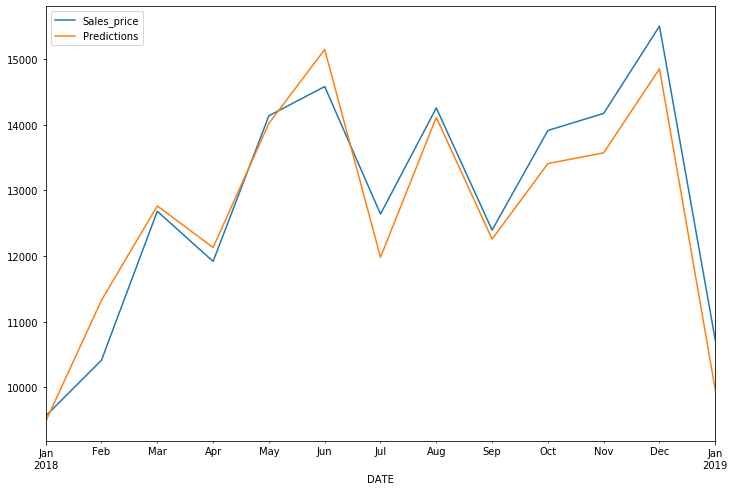

In [184]:
test.plot(figsize=(12,8))

In [185]:
test.head()

,Sales_price,Predictions
DATE,,
2018-01-01,9564,9481.749174
2018-02-01,10415,11328.157018
2018-03-01,12683,12764.474063
2018-04-01,11919,12130.988726
2018-05-01,14138,14022.088866


In [186]:
test['resid'] = test['Sales_price']-test['Predictions']

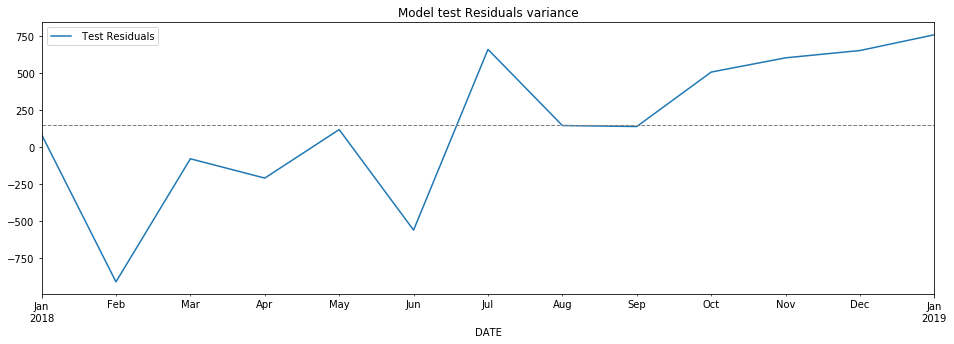

In [187]:
test['resid'].plot(figsize=(16,5),title='Model test Residuals variance', label=' Test Residuals',legend=True)
plt.axhline(test['resid'].mean(), color='grey', linestyle='--', linewidth=1)
plt.show()

[]

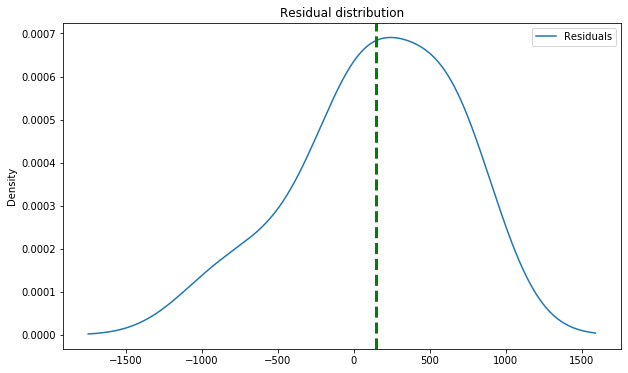

In [194]:
test['resid'].plot.kde(title= 'Residual distribution', figsize= (10,6), label='Residuals',legend=True);
plt.axvline(test['resid'].mean(), color='g', linestyle='dashed', linewidth=3)
plt.plot()

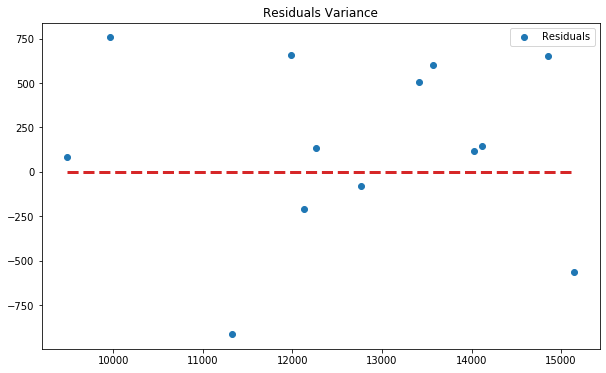

In [195]:
plt.figure(figsize= (10,6))
plt.scatter(x=test.Predictions,y=test['resid'], label='Residuals')
plt.plot( [min(test.Predictions),max(test.Predictions)],[0,0] ,color='tab:red', lw=3, linestyle='--');
plt.title('Residuals Variance')
plt.legend()
plt.show()

In [ ]:
model.save('alcohol_model.h5')

In [ ]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')
new_model.summary()